In [64]:
#!/usr/bin/env python
from __future__ import division, print_function, absolute_import
from collections import OrderedDict, defaultdict
import numpy as np
import simdna.synthetic as synthetic
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve)

method_to_saved_scores = OrderedDict([
    ('gkmexplain', 'gkmexplain_imp_scores.npy'),
    ('ism', 'ism_imp_scores.npy'),
    ('shap2000bg20', 'shap2000_bg20_imp_scores.npy'),
    ('shap2000bg200', 'shap2000_bg200_imp_scores.npy'),
    ('shap20000bg20', 'shap20000_bg20_imp_scores.npy')
])

simdna_file = "sequences.simdata.gz"
data = synthetic.read_simdata_file(simdna_file)
fa_file_of_interest = "test_positives.fa"
seq_ids_of_interest = [x.rstrip()[1:] for (i,x)
                       in enumerate(open(fa_file_of_interest))
                       if i%2==0]
seq_ids_of_interest_set = set(seq_ids_of_interest)

method_to_seq_id_to_scores = {}
for method_name in method_to_saved_scores:
    scores = np.load(method_to_saved_scores[method_name])
    assert(len(seq_ids_of_interest)==len(scores))
    seq_id_to_scores = dict(zip(seq_ids_of_interest,scores))
    method_to_seq_id_to_scores[method_name] = seq_id_to_scores


#covered_positions marks a position as a 1 if it overlaps
# an embedded motif
seq_id_to_covered_positions = {}
motif_id_to_hit_locations = defaultdict(list)
motif_id_to_motif_length = {}
#For each motif, we need a mapping from the motif
# to the positives locations
for (the_embeddings, seq_id, the_seq) in zip(data.embeddings,
                                             data.ids, data.sequences):
    if (seq_id in seq_ids_of_interest_set):  
        embedded_positions = np.zeros(len(the_seq))
        for embedding in the_embeddings:
            motif_start_loc = embedding.startPos 
            motif_len = len(embedding.what)
            motif_end_loc = motif_start_loc+motif_len
            embedded_positions[motif_start_loc:motif_end_loc] = 1.0
            motif_name = embedding.what.getDescription()
            if (motif_name in motif_id_to_motif_length):
                assert (motif_id_to_motif_length[motif_name]==motif_len)
            else:
                motif_id_to_motif_length[motif_name] = motif_len
            motif_id_to_hit_locations[motif_name].append(
                (seq_id,motif_start_loc))
        seq_id_to_covered_positions[seq_id] = embedded_positions 

#find windows of a given length that do not overlap any motif
motif_len_to_negatives = defaultdict(list)                            
for motif_len in set(motif_id_to_motif_length.values()):
    for seq_id,covered_positions in seq_id_to_covered_positions.items():
        cumsum = np.array([0]+list(np.cumsum(covered_positions)))
        window_sums = cumsum[motif_len:]-cumsum[0:-motif_len]
        null_windows = [(seq_id,x) for x in
                        np.nonzero(window_sums==0)[0]]
        motif_len_to_negatives[motif_len].extend(null_windows)

On motif GATA_disc1
num pos 610
num neg 50787


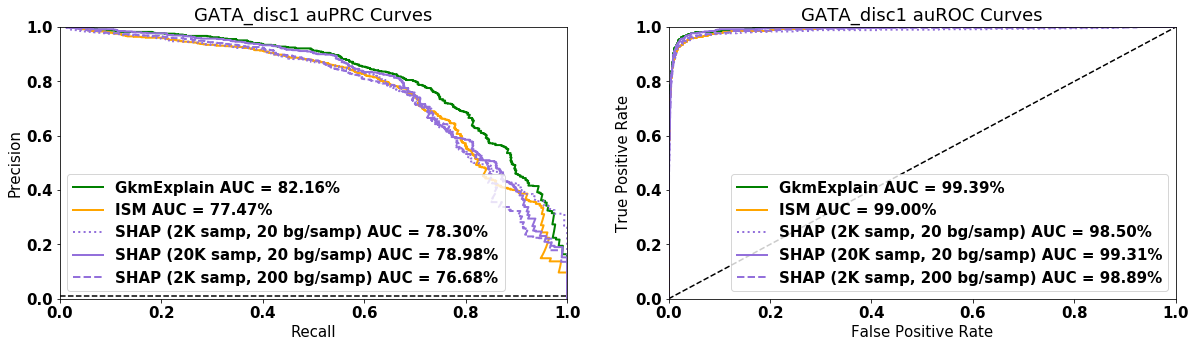

On motif GATA_disc1
num pos 610
num neg 50787


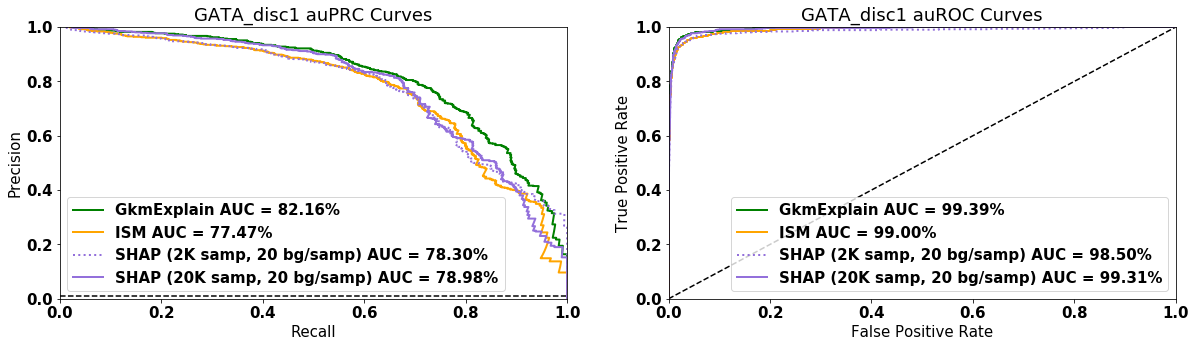

On motif TAL1_known1
num pos 620
num neg 43385


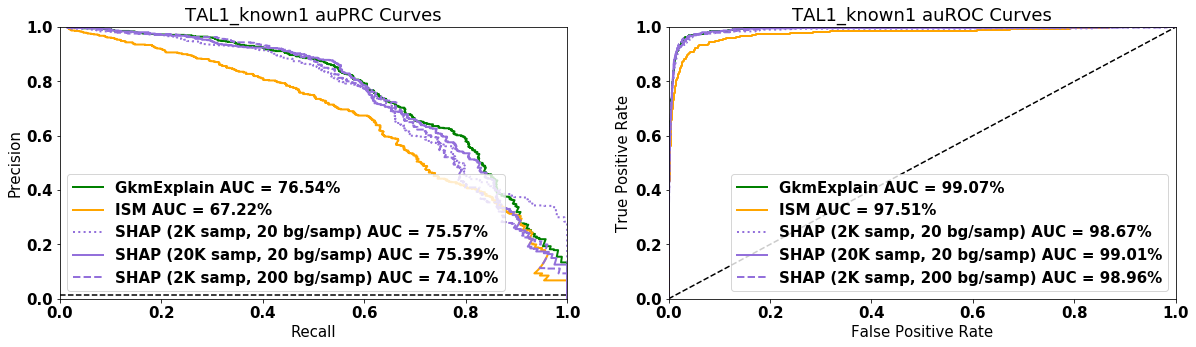

On motif TAL1_known1
num pos 620
num neg 43385


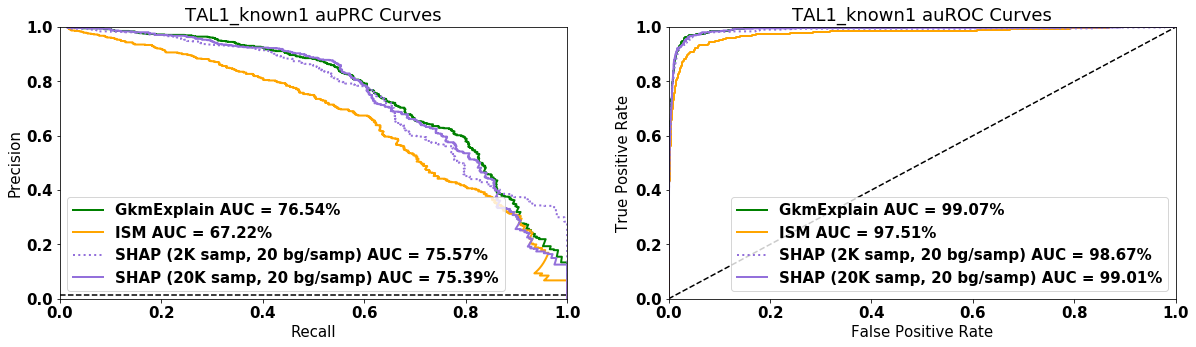

In [67]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

method_name_to_plot_style = {
    'gkmexplain': {'color':'green'},
    'ism': {'color':'orange'},
    'shap2000bg20': {'color':'mediumpurple','linestyle':":"},
    'shap20000bg20': {'color':'mediumpurple'},
    'shap2000bg200': {'color':'mediumpurple','linestyle':"--"}
}

method_name_nicename = {
    'gkmexplain': 'GkmExplain',
    'ism': 'ISM',
    'shap2000bg20': 'SHAP (2K samp, 20 bg/samp)',
    'shap20000bg20': 'SHAP (20K samp, 20 bg/samp)',
    'shap2000bg200': 'SHAP (2K samp, 200 bg/samp)'
}
    
for motif_id in sorted(motif_id_to_motif_length.keys()):
    
    for methods_to_plot in [['gkmexplain', 'ism', 'shap2000bg20', 'shap20000bg20', 'shap2000bg200'],
                            ['gkmexplain', 'ism', 'shap2000bg20', 'shap20000bg20']]:
        
        print("On motif",motif_id)
        motif_len = motif_id_to_motif_length[motif_id]
        pos_locs = motif_id_to_hit_locations[motif_id]
        neg_locs = motif_len_to_negatives[motif_len]
        print("num pos",len(pos_locs))
        print("num neg",len(neg_locs))
        all_locs = list(pos_locs)+list(neg_locs)
        loc_labels = [1 for x in pos_locs]+[0 for x in neg_locs]

        f,axarr = plt.subplots(1,2, figsize=(20,5))
        plt.subplot(122)
        plt.title(motif_id+' auROC Curves')
        plt.plot([0, 1], [0, 1], color='black', linestyle='--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

        pos_frac = float(len(pos_locs))/(len(pos_locs)+len(neg_locs))
        plt.subplot(121)
        plt.title(motif_id+' auPRC Curves')
        plt.plot([0, 1], [pos_frac, pos_frac], color='black', linestyle='--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('Precision')
        plt.xlabel('Recall') 
    
        for method_name in methods_to_plot:
            #print(method_name)
            seq_id_to_scores = method_to_seq_id_to_scores[method_name] 
            seq_id_to_windowsums = {}
            for seq_id,scores in seq_id_to_scores.items():
                cumsum = np.array([0]+list(np.cumsum(np.sum(scores,axis=-1))))
                windowsums = cumsum[motif_len:]-cumsum[:-motif_len]
                seq_id_to_windowsums[seq_id] = windowsums
            loc_scores = [seq_id_to_windowsums[seq_id][pos]
                          for (seq_id, pos) in all_locs]
            auroc = roc_auc_score(y_true=loc_labels,
                                  y_score=loc_scores)
            auprc = average_precision_score(y_true=loc_labels,
                                            y_score=loc_scores)

            plt.subplot(122)
            fpr, tpr, rocthresholds = roc_curve(
                loc_labels, loc_scores, pos_label=1)
            plt.plot(fpr, tpr,
                     label = method_name_nicename[method_name]+(' AUC = %0.2f' % (100*auroc))+"%",
                     linewidth=2,
                     **method_name_to_plot_style[method_name])
            plt.legend(loc = 'lower right')

            plt.subplot(121)
            precision, recall, thresholds = precision_recall_curve(
                loc_labels, loc_scores, pos_label=1)
            plt.plot(precision, recall,
                     label = method_name_nicename[method_name]+(' AUC = %0.2f' % (100*auprc))+"%",
                     linewidth=2,
                     **method_name_to_plot_style[method_name])
            plt.legend(loc = 'lower left')

        plt.show()